In [7]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [8]:
import glob
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torch
from torchvision import transforms
import av
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import functools

# Define base directory paths
DATA_DIR = 'data_synced'  # Directory containing processed CSV files
VIDEO_BASE_DIR = 'data/extracted/Chunk_1'  # Directory containing original videos

class DrivingDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        # Load the CSV data
        self.data = pd.read_csv(csv_file)
        
        # Get video path from CSV filename
        filename = os.path.basename(csv_file)
        name_without_ext = filename[:-4]  # Remove .csv
        
        # Split into parts and reconstruct the original path
        parts = name_without_ext.split('_')
        segment_num = parts[-1]  # Get segment number
        base_path = name_without_ext[:-len(segment_num)-1]  # Remove _4 from the end
        
        # Construct full video path
        self.video_path = os.path.join(VIDEO_BASE_DIR, base_path, segment_num, 'video.hevc')
        
        print(f"CSV file: {csv_file}")
        print(f"Video path: {self.video_path}")
        
        # Verify video exists
        if not os.path.exists(self.video_path):
            raise FileNotFoundError(f"Video file not found: {self.video_path}")
        
        # Load video frames
        print(f"Loading video frames...")
        self.frames = self.load_video_frames()
        
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

    def load_video_frames(self):
        frames = []
        container = av.open(self.video_path)
        stream = container.streams.video[0]
        stream.thread_type = "AUTO"
        
        for frame in container.decode(video=0):
            frame = frame.to_ndarray(format='rgb24')
            frame = Image.fromarray(frame)
            frame = frame.resize((400, 240), Image.Resampling.BILINEAR)
            frames.append(np.array(frame))
        
        container.close()
        return frames

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        frame = self.frames[idx]
        row = self.data.iloc[idx]
        
        if self.transform:
            frame = self.transform(frame)
        
        # Get current sensor data (inputs)
        # Fix speed by removing brackets and converting to float
        speed_value = float(row['speed'].strip('[]'))
        
        current_data = torch.tensor([
            speed_value,  # Clean speed value
            row['gyro_x'], row['gyro_y'], row['gyro_z'],
            row['accel_x'], row['accel_y'], row['accel_z'],
            row['velocity_x'], row['velocity_y'], row['velocity_z'],
            row['current_steering'],  # Current steering angle as input
        ], dtype=torch.float32)
        
        # Get future steering angle (target)
        target = torch.tensor(row['future_steering'], dtype=torch.float32)
        
        return frame, current_data, target

# Get list of all CSV files in data_synced
csv_files = [f for f in glob.glob('data_synced/*.csv') if 'combined_dataset.csv' not in f]
print(f"Found {len(csv_files)} CSV files")

def load_dataset_parallel(csv_file):
    try:
        dataset = DrivingDataset(csv_file)
        tqdm.write(f"Successfully loaded dataset from {csv_file}")
        return dataset
    except Exception as e:
        tqdm.write(f"Error loading {csv_file}: {str(e)}")
        return None

# Create datasets for each segment in parallel
with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers based on your CPU
    datasets = list(tqdm(
        executor.map(load_dataset_parallel, csv_files),
        desc="Loading datasets",
        total=len(csv_files)
    ))
    
# Filter out None values (failed loads)
datasets = [d for d in datasets if d is not None]

if not datasets:
    raise RuntimeError("No datasets were successfully loaded!")

# Combine all datasets
full_dataset = ConcatDataset(datasets)
total_size = len(full_dataset)

# Split dataset into train, validation, and test sets (70%, 15%, 15%)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

print(f"\nDataset sizes:")
print(f"Total samples: {total_size}")
print(f"Train: {len(train_dataset)} ({len(train_dataset)/total_size*100:.1f}%)")
print(f"Validation: {len(val_dataset)} ({len(val_dataset)/total_size*100:.1f}%)")
print(f"Test: {len(test_dataset)} ({len(test_dataset)/total_size*100:.1f}%)")

# Create data loaders with num_workers=0 for now
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

Found 7 CSV files


Loading datasets:   0%|          | 0/7 [00:00<?, ?it/s]

CSV file: data_synced\b0c9d2329ad1606b_2018-07-27--06-03-57_6.csv
Video path: data/extracted/Chunk_1\b0c9d2329ad1606b_2018-07-27--06-03-57\6\video.hevc
Loading video frames...
CSV file: data_synced\b0c9d2329ad1606b_2018-07-27--06-50-48_7.csv
Video path: data/extracted/Chunk_1\b0c9d2329ad1606b_2018-07-27--06-50-48\7\video.hevc
CSV file: data_synced\b0c9d2329ad1606b_2018-07-27--06-50-48_12.csv
Video path: data/extracted/Chunk_1\b0c9d2329ad1606b_2018-07-27--06-50-48\12\video.hevc
Loading video frames...
Loading video frames...
CSV file: data_synced\b0c9d2329ad1606b_2018-07-29--11-17-20_4.csv
Video path: data/extracted/Chunk_1\b0c9d2329ad1606b_2018-07-29--11-17-20\4\video.hevc
Loading video frames...


Loading datasets:  14%|█▍        | 1/7 [00:08<00:51,  8.54s/it]

Successfully loaded dataset from data_synced\b0c9d2329ad1606b_2018-07-29--11-17-20_4.csv
CSV file: data_synced\b0c9d2329ad1606b_2018-07-29--12-02-42_27.csv
Video path: data/extracted/Chunk_1\b0c9d2329ad1606b_2018-07-29--12-02-42\27\video.hevc
Loading video frames...
Successfully loaded dataset from data_synced\b0c9d2329ad1606b_2018-07-27--06-50-48_12.csv
Successfully loaded dataset from data_synced\b0c9d2329ad1606b_2018-07-27--06-50-48_7.csv
CSV file: data_synced\b0c9d2329ad1606b_2018-07-29--12-02-42_30.csv
Video path: data/extracted/Chunk_1\b0c9d2329ad1606b_2018-07-29--12-02-42\30\video.hevc
Loading video frames...
CSV file: data_synced\b0c9d2329ad1606b_2018-07-30--13-03-07_16.csv
Video path: data/extracted/Chunk_1\b0c9d2329ad1606b_2018-07-30--13-03-07\16\video.hevc
Loading video frames...
Successfully loaded dataset from data_synced\b0c9d2329ad1606b_2018-07-27--06-03-57_6.csv


Loading datasets: 100%|██████████| 7/7 [00:16<00:00,  2.34s/it]

Successfully loaded dataset from data_synced\b0c9d2329ad1606b_2018-07-29--12-02-42_27.csv
Successfully loaded dataset from data_synced\b0c9d2329ad1606b_2018-07-30--13-03-07_16.csv
Successfully loaded dataset from data_synced\b0c9d2329ad1606b_2018-07-29--12-02-42_30.csv

Dataset sizes:
Total samples: 8376
Train: 5863 (70.0%)
Validation: 1256 (15.0%)
Test: 1257 (15.0%)


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

class ResBlock(nn.Module):
    """
    Basic ResNet block with optional downsampling.
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        
        # First convolution block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Second convolution block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection (identity or 1x1 conv)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # Skip connection
        out = F.relu(out)
        return out

class SteeringResNet(nn.Module):
    """
    ResNet-based model for predicting steering angles at t+200ms.
    Architecture:
    1. Initial Conv layer
    2. ResNet blocks with increasing channels
    3. Sensor processing branch
    4. Combined processing for final prediction
    """
    def __init__(self):
        super(SteeringResNet, self).__init__()
        self.sensor_input_size = 11  # speed, gyro(3), accel(3), velocity(3), current_steering

        # Initial processing
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # ResNet blocks
        self.layer1 = self._make_layer(64, 64, 2)    # Output: 64 channels
        self.layer2 = self._make_layer(64, 128, 2, stride=2)  # Output: 128 channels
        self.layer3 = self._make_layer(128, 256, 2, stride=2)  # Output: 256 channels
        
        # Sensor processing branch
        self.sensor_net = nn.Sequential(
            nn.Linear(self.sensor_input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64)
        )

        # Calculate final feature size
        with torch.no_grad():
            dummy_img = torch.zeros(1, 3, 240, 400)
            dummy_features = self.initial(dummy_img)
            dummy_features = self.layer1(dummy_features)
            dummy_features = self.layer2(dummy_features)
            dummy_features = self.layer3(dummy_features)
            self.feature_size = dummy_features.view(-1).shape[0]
            print(f"CNN Feature size: {self.feature_size}")

        # Combined processing
        self.final = nn.Sequential(
            nn.Linear(self.feature_size + 64, 256),  # CNN features + sensor features
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1),  # Small dropout for regularization
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 1)
        )

    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        """Helper function to create a layer of ResBlocks"""
        layers = []
        layers.append(ResBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, image, sensor_data):
        """
        Forward pass through the network.
        Args:
            image (torch.Tensor): Shape [B, 3, 240, 400]
            sensor_data (torch.Tensor): Shape [B, 11]
        Returns:
            torch.Tensor: Predicted steering angle at t+200ms, shape [B, 1]
        """
        # Image processing branch
        x = self.initial(image)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)  # Flatten CNN features

        # Sensor processing branch
        sensor_features = self.sensor_net(sensor_data)

        # Combine features
        combined = torch.cat([x, sensor_features], dim=1)
        
        # Final prediction
        steering = self.final(combined)
        return steering

CNN Feature size: 96000

Starting training...

GPU Information:
CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4090
Device memory: 25.76 GB
Training on cuda:0


Epoch 1/50: 100%|██████████| 92/92 [00:07<00:00, 13.07it/s, loss=5.71e+3]


Epoch 1: Train Loss: 4295.7948, Val Loss: 2650.5643


Epoch 2/50: 100%|██████████| 92/92 [00:07<00:00, 13.03it/s, loss=475]    


Epoch 2: Train Loss: 2926.7407, Val Loss: 1522.8185


Epoch 3/50: 100%|██████████| 92/92 [00:06<00:00, 13.15it/s, loss=195]    


Epoch 3: Train Loss: 2062.5161, Val Loss: 528.4984


Epoch 4/50: 100%|██████████| 92/92 [00:06<00:00, 13.24it/s, loss=435]    


Epoch 4: Train Loss: 1233.9218, Val Loss: 259.9533


Epoch 5/50: 100%|██████████| 92/92 [00:06<00:00, 13.20it/s, loss=1.75e+3]


Epoch 5: Train Loss: 773.7987, Val Loss: 302.2844


Epoch 6/50: 100%|██████████| 92/92 [00:07<00:00, 13.11it/s, loss=399]    


Epoch 6: Train Loss: 644.2886, Val Loss: 193.1476


Epoch 7/50: 100%|██████████| 92/92 [00:06<00:00, 13.20it/s, loss=179]    


Epoch 7: Train Loss: 480.1712, Val Loss: 269.9525


Epoch 8/50: 100%|██████████| 92/92 [00:06<00:00, 13.49it/s, loss=140]    


Epoch 8: Train Loss: 360.0850, Val Loss: 108.0891


Epoch 9/50: 100%|██████████| 92/92 [00:06<00:00, 13.73it/s, loss=333]    


Epoch 9: Train Loss: 402.5343, Val Loss: 100.4878


Epoch 10/50: 100%|██████████| 92/92 [00:06<00:00, 13.54it/s, loss=616]    


Epoch 10: Train Loss: 323.0087, Val Loss: 1210.2315


Epoch 11/50: 100%|██████████| 92/92 [00:06<00:00, 13.25it/s, loss=372]    


Epoch 11: Train Loss: 293.6696, Val Loss: 235.3072


Epoch 12/50: 100%|██████████| 92/92 [00:06<00:00, 13.49it/s, loss=223]    


Epoch 12: Train Loss: 262.2248, Val Loss: 194.3089


Epoch 13/50: 100%|██████████| 92/92 [00:06<00:00, 13.32it/s, loss=74.3]   


Epoch 13: Train Loss: 274.6144, Val Loss: 149.8460


Epoch 14/50: 100%|██████████| 92/92 [00:07<00:00, 13.05it/s, loss=109]    


Epoch 14: Train Loss: 234.8841, Val Loss: 63.0131


Epoch 15/50: 100%|██████████| 92/92 [00:06<00:00, 13.19it/s, loss=442] 


Epoch 15: Train Loss: 188.8425, Val Loss: 156.5124


Epoch 16/50: 100%|██████████| 92/92 [00:06<00:00, 13.47it/s, loss=124] 


Epoch 16: Train Loss: 184.1299, Val Loss: 55.8896


Epoch 17/50: 100%|██████████| 92/92 [00:06<00:00, 13.62it/s, loss=338] 


Epoch 17: Train Loss: 189.4744, Val Loss: 100.7574


Epoch 18/50: 100%|██████████| 92/92 [00:06<00:00, 13.54it/s, loss=33.4]


Epoch 18: Train Loss: 166.1071, Val Loss: 87.2806


Epoch 19/50: 100%|██████████| 92/92 [00:06<00:00, 13.65it/s, loss=68.1]   


Epoch 19: Train Loss: 204.0354, Val Loss: 109.9761


Epoch 20/50: 100%|██████████| 92/92 [00:06<00:00, 13.64it/s, loss=74.6]


Epoch 20: Train Loss: 182.9241, Val Loss: 91.8736


Epoch 21/50: 100%|██████████| 92/92 [00:06<00:00, 13.65it/s, loss=278] 


Epoch 21: Train Loss: 139.6773, Val Loss: 42.5209


Epoch 22/50: 100%|██████████| 92/92 [00:06<00:00, 13.53it/s, loss=247]    


Epoch 22: Train Loss: 149.7667, Val Loss: 96.9881


Epoch 23/50: 100%|██████████| 92/92 [00:06<00:00, 13.63it/s, loss=2.28e+3]


Epoch 23: Train Loss: 151.0434, Val Loss: 78.7476


Epoch 24/50: 100%|██████████| 92/92 [00:06<00:00, 13.61it/s, loss=106]    


Epoch 24: Train Loss: 140.1356, Val Loss: 114.5282


Epoch 25/50: 100%|██████████| 92/92 [00:06<00:00, 13.62it/s, loss=370]    


Epoch 25: Train Loss: 155.6348, Val Loss: 83.3240


Epoch 26/50: 100%|██████████| 92/92 [00:06<00:00, 13.56it/s, loss=352] 


Epoch 26: Train Loss: 161.3165, Val Loss: 118.4954


Epoch 27/50: 100%|██████████| 92/92 [00:06<00:00, 13.64it/s, loss=205] 


Epoch 27: Train Loss: 146.3309, Val Loss: 93.0739


Epoch 28/50: 100%|██████████| 92/92 [00:06<00:00, 13.65it/s, loss=77.7]


Epoch 28: Train Loss: 131.5392, Val Loss: 61.7724


Epoch 29/50: 100%|██████████| 92/92 [00:06<00:00, 13.64it/s, loss=89.6]


Epoch 29: Train Loss: 132.4732, Val Loss: 51.7310
Early stopping triggered at epoch 29


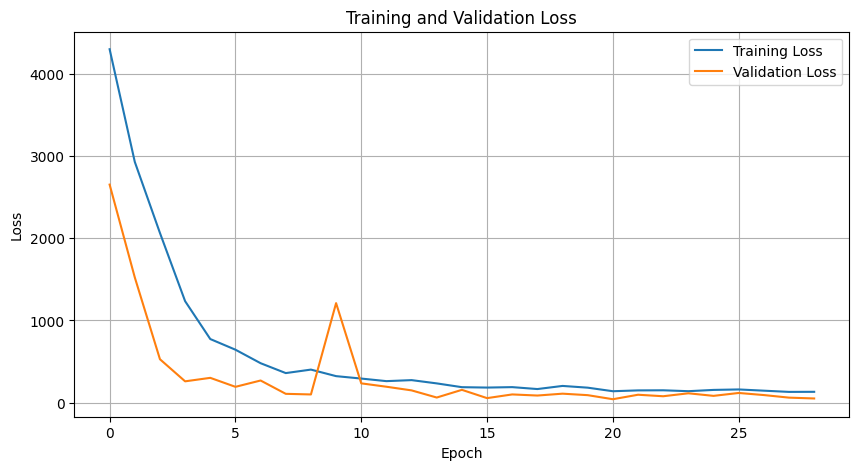


Model saved to 'v4_ResNet.pth'

Testing the model...

Test Results (Predicting Steering Angle at t+200ms):
MSE: 57.8574 degrees²
MAE: 5.5892 degrees
Predictions within 1°: 7.5%
Predictions within 3°: 26.8%
Predictions within 5°: 55.8%


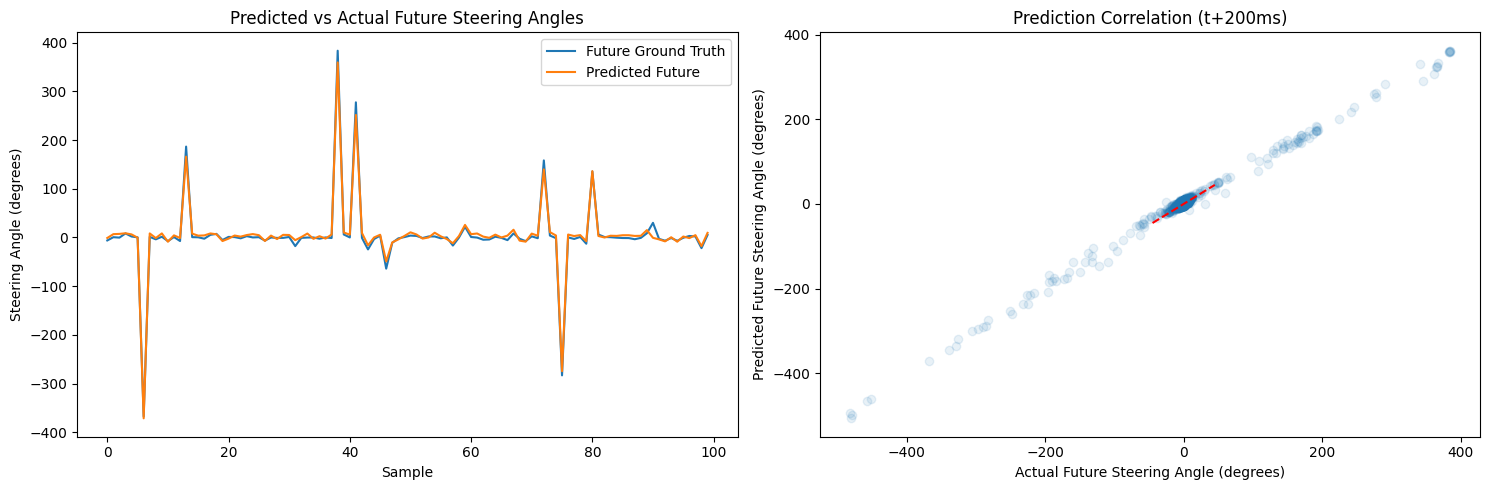


Visualizing some predictions...


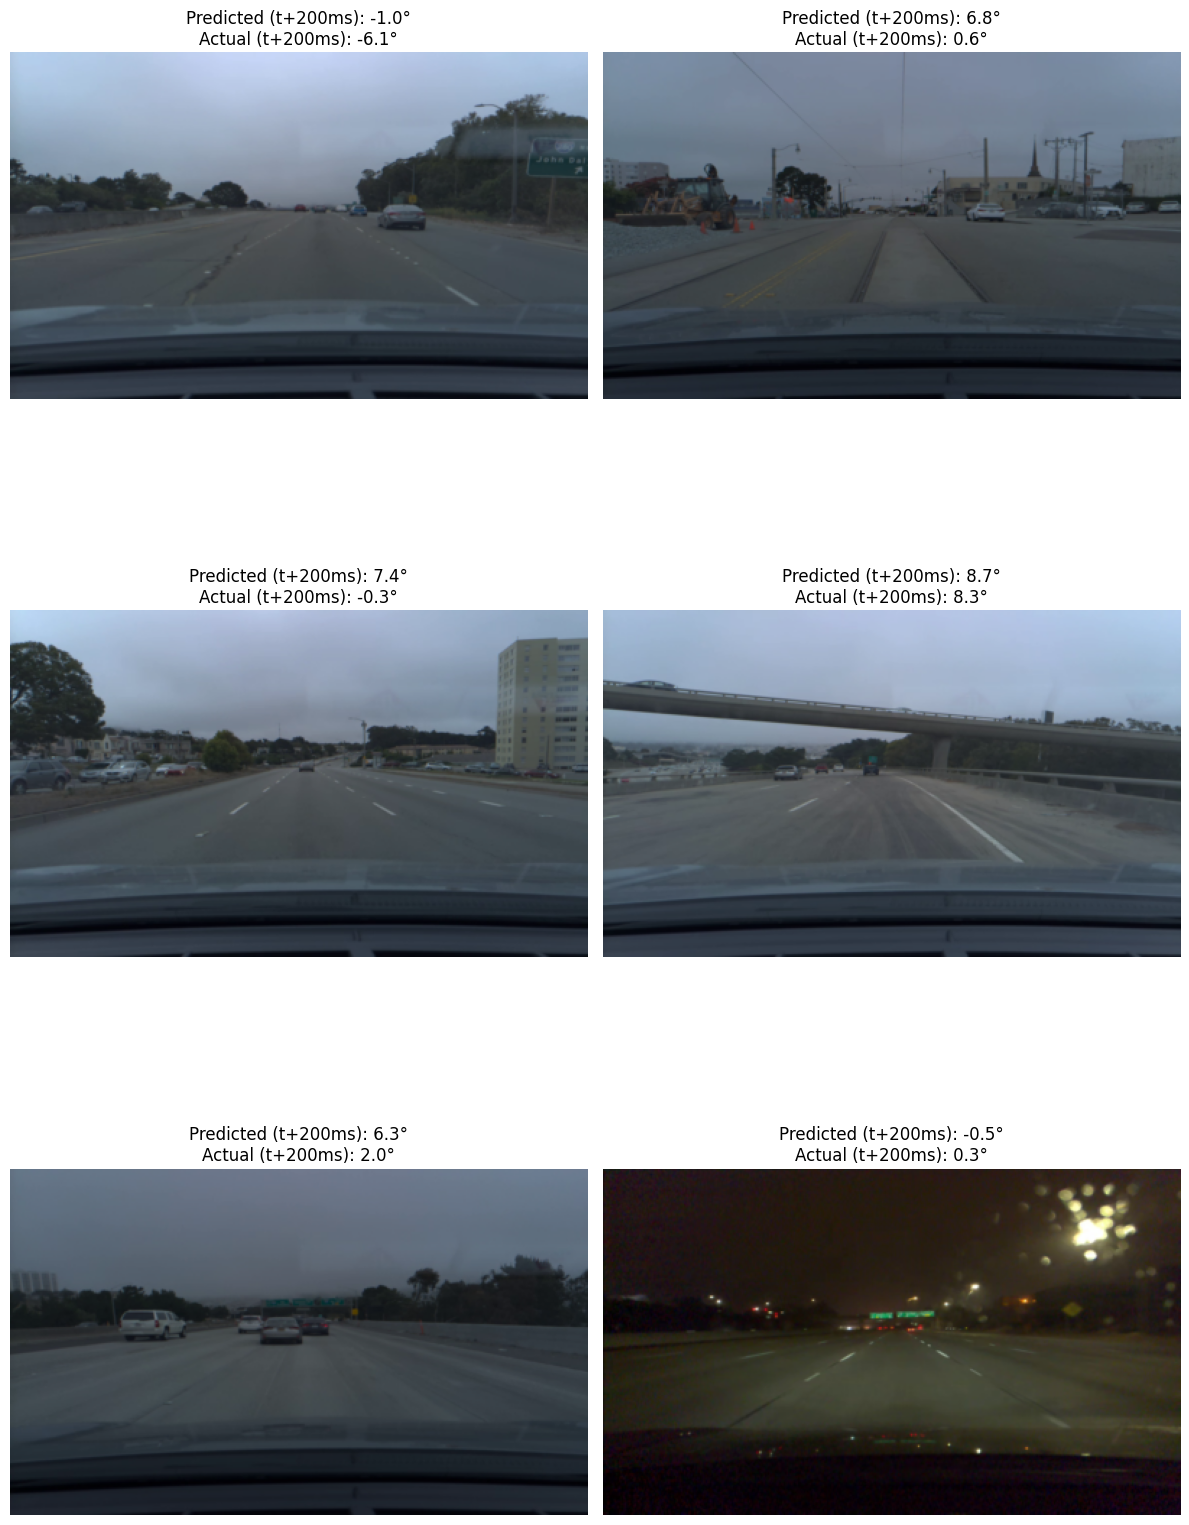

In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    """
    Train the model with early stopping.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Add this before training starts
    print("\nGPU Information:")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"Current device: {torch.cuda.current_device()}")
        print(f"Device name: {torch.cuda.get_device_name()}")
        print(f"Device memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    model.to(device)
    print(f"Training on {device}")

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Use tqdm for progress bar
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
            for images, sensor_data, targets in pbar:
                images = images.to(device)
                sensor_data = sensor_data.to(device)
                targets = targets.to(device).view(-1, 1)  # Future steering angle

                optimizer.zero_grad()
                outputs = model(images, sensor_data)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                pbar.set_postfix({'loss': loss.item()})

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_loss = 0.0

        with torch.no_grad():
            for images, sensor_data, targets in val_loader:
                images = images.to(device)
                sensor_data = sensor_data.to(device)
                targets = targets.to(device).view(-1, 1)

                outputs = model(images, sensor_data)
                loss = criterion(outputs, targets)
                running_loss += loss.item() * images.size(0)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f'Epoch {epoch+1}: Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Load best model
    if best_model is not None:
        model.load_state_dict(best_model)

    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, train_losses, val_losses

def test_model(model, test_loader):
    """
    Test the model with steering-specific metrics for future steering angle prediction.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, sensor_data, target_angle in test_loader:  # Now unpacking three values
            images = images.to(device)
            sensor_data = sensor_data.to(device)
            target_angle = target_angle.to(device).view(-1, 1)  # Future steering angle

            outputs = model(images, sensor_data)
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(target_angle.cpu().numpy())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Calculate metrics
    mse = np.mean((all_preds - all_targets) ** 2)
    mae = np.mean(np.abs(all_preds - all_targets))
    within_1_deg = np.mean(np.abs(all_preds - all_targets) < 1.0) * 100
    within_3_deg = np.mean(np.abs(all_preds - all_targets) < 3.0) * 100
    within_5_deg = np.mean(np.abs(all_preds - all_targets) < 5.0) * 100

    print("\nTest Results (Predicting Steering Angle at t+200ms):")
    print(f"MSE: {mse:.4f} degrees²")
    print(f"MAE: {mae:.4f} degrees")
    print(f"Predictions within 1°: {within_1_deg:.1f}%")
    print(f"Predictions within 3°: {within_3_deg:.1f}%")
    print(f"Predictions within 5°: {within_5_deg:.1f}%")

    # Visualizations
    plt.figure(figsize=(15, 5))

    # Prediction vs Ground Truth
    plt.subplot(1, 2, 1)
    plt.plot(all_targets[:100], label='Future Ground Truth')
    plt.plot(all_preds[:100], label='Predicted Future')
    plt.xlabel('Sample')
    plt.ylabel('Steering Angle (degrees)')
    plt.title('Predicted vs Actual Future Steering Angles')
    plt.legend()

    # Correlation plot
    plt.subplot(1, 2, 2)
    plt.scatter(all_targets, all_preds, alpha=0.1)
    plt.plot([-45, 45], [-45, 45], 'r--')
    plt.xlabel('Actual Future Steering Angle (degrees)')
    plt.ylabel('Predicted Future Steering Angle (degrees)')
    plt.title('Prediction Correlation (t+200ms)')

    plt.tight_layout()
    plt.show()

# Initialize and train
model = SteeringResNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

print("\nStarting training...")
model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=50,
    patience=8
)

# Save the trained model
torch.save(model.state_dict(), 'v4_ResNet.pth')
print("\nModel saved to 'v4_ResNet.pth'")

# Test the model
print("\nTesting the model...")
test_model(model, test_loader)

def visualize_single_batch(model, test_loader):
    model.eval()
    device = next(model.parameters()).device

    # Get a single batch
    images, sensor_data, targets = next(iter(test_loader))
    images = images.to(device)
    sensor_data = sensor_data.to(device)

    with torch.no_grad():
        predictions = model(images, sensor_data)

    # Convert to numpy for visualization
    predictions = predictions.cpu().numpy()
    targets = targets.numpy()

    # Plot a few examples
    fig, axes = plt.subplots(3, 2, figsize=(12, 18))
    for i in range(min(6, len(predictions))):
        ax = axes[i//2, i%2]

        # Get the original image
        img = images[i].cpu().numpy().transpose(1, 2, 0)  # Changed inputs to images

        # Denormalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(f'Predicted (t+200ms): {predictions[i][0]:.1f}°\nActual (t+200ms): {targets[i]:.1f}°')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualizing some predictions...")
visualize_single_batch(model, test_loader)